
# Latent Function Inference with Pyro + GPyTorch (Low-Level Interface)

## Overview

In this example, we will give an overview of the low-level Pyro-GPyTorch integration.
The low-level interface makes it possible to write GP models in a Pyro-style -- i.e. defining your own `model` and `guide` functions.

These are the key differences between the high-level and low-level interface:

**High level interface**

- Base class is `gpytorch.models.PyroGP`.
- GPyTorch automatically defines the `model` and `guide` functions for Pyro.
- Best used when *prediction* is the primary goal

**Low level interface**

- Base class is `gpytorch.models.ApproximateGP`.
- User defines the `model` and `guide` functions for Pyro.
- Best used when *inference* is the primary goal

In [1]:
import math
import torch
import pyro
import tqdm
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

This example uses a GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:

$$y \sim \text{Exponential} (\lambda),$$

where:

$$\lambda = \exp(f) \in (0,+\infty)$$

is a GP link function, which transforms the latent gaussian process variable:

$$f \sim GP \in (-\infty,+\infty).$$


In other words, given inputs $X$ and observations $Y$ drawn from exponential distribution with $\lambda = \lambda(X)$, we want to find $\lambda(X)$.

C:\Users\queim\AppData\Local\Temp\ipykernel_13668\4002366916.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[i] = np.random.exponential(scale(x), 1)


Text(0.5, 1.0, 'Samples from exp. distrib.')

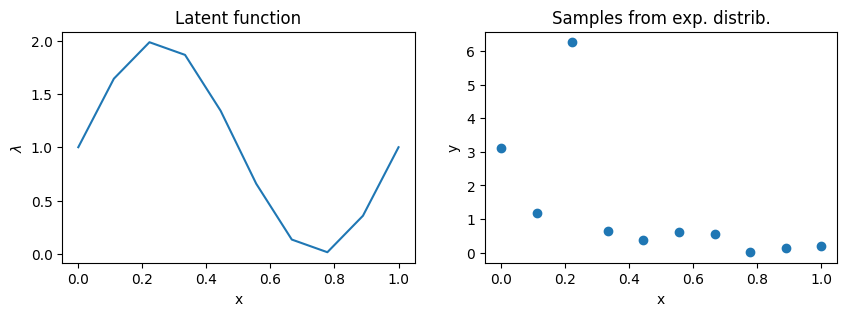

In [ ]:
# Here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2 * math.pi * x) + 1 

# Generate synthetic data
# here we generate some synthetic samples
NSamp = 100

X = np.linspace(0, 1, 10) 

fig, (lambdaf, samples) = plt.subplots(1, 2, figsize=(10, 3))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

Y = np.zeros_like(X)
for i,x in enumerate(X):
    Y[i] = np.random.exponential(scale(x), 1)
samples.scatter(X,Y)
samples.set_xlabel('x')
samples.set_ylabel('y')
samples.set_title('Samples from exp. distrib.')

In [3]:
train_x = torch.tensor(X).float()
train_y = torch.tensor(Y).float()

## Using the low-level Pyro/GPyTorch interface

The low-level iterface should look familiar if you've written Pyro models/guides before. We'll use a `gpytorch.models.ApproximateGP` object to model the GP. To use the low-level interface, this object needs to define 3 functions:

- `forward(x)` - which computes the prior GP mean and covariance at the supplied times.
- `guide(x)` - which defines the approximate GP posterior.
- `model(x)` - which does the following 3 things

  - Computes the GP prior at `x`
  - Converts GP function samples into scale function samples, using the link function defined above.
  - Sample from the observed distribution `p(y | f)`. (This takes the place of a gpytorch `Likelihood` that we would've used in the high-level interface).

In [4]:
class PVGPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=64, name_prefix="mixture_gp"):
        self.name_prefix = name_prefix
        
        # Define all the variational stuff
        inducing_points = torch.linspace(0, 1, num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        )
        
        # Standard initializtation
        super().__init__(variational_strategy)
        
        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)
    
    def guide(self, x, y):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            pyro.sample(self.name_prefix + ".f(x)", function_dist)
    
    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)
        
        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)
        
        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            # Use the link function to convert GP samples into scale samples
            scale_samples = function_samples.exp()

            # Sample from observed distribution
            return pyro.sample(
                self.name_prefix + ".y",
                pyro.distributions.Exponential(scale_samples.reciprocal()),  # rate = 1 / scale
                obs=y
            )

In [5]:
model = PVGPRegressionModel()

In [10]:
import torch
import gpytorch
import pyro
from pyro.nn import PyroModule

class CombinedLikelihood(PyroModule):
    def __init__(self, weight_laplace=0.5, weight_studentt=0.5, df=2.0):
        super().__init__()
        self.weight_laplace = weight_laplace
        self.weight_studentt = weight_studentt
        self.df = df  # Degrees of freedom for StudentT

    def log_prob(self, function_samples, y):
        # Laplace distribution
        laplace_dist = torch.distributions.Laplace(function_samples, torch.ones_like(function_samples))
        laplace_log_prob = laplace_dist.log_prob(y)
        
        # StudentT distribution
        studentt_dist = torch.distributions.StudentT(self.df, function_samples, torch.ones_like(function_samples))
        studentt_log_prob = studentt_dist.log_prob(y)
        
        # Combine log probabilities (log-sum-exp for numerical stability)
        combined_log_prob = torch.logsumexp(
            torch.stack([
                self.weight_laplace * laplace_log_prob,
                self.weight_studentt * studentt_log_prob,
            ], dim=0),
            dim=0
        )
        return combined_log_prob

class PVGPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=64, name_prefix="mixture_gp", weight_laplace=0.5, weight_studentt=0.5, df=2.0):
        self.name_prefix = name_prefix

        # Variational setup
        inducing_points = torch.linspace(0, 1, num_inducing).unsqueeze(-1)  # Ensure 2D input
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing),
        )
        
        super().__init__(variational_strategy)
        
        # Mean and covariance
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        # Custom combined likelihood
        self.likelihood = CombinedLikelihood(
            weight_laplace=weight_laplace,
            weight_studentt=weight_studentt,
            df=df
        )

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)

        # GP prior p(f)
        function_dist = self.pyro_model(x)

        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample latent function values f(x)
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            # Use custom likelihood for observed data
            pyro.factor(self.name_prefix + ".likelihood",
                        self.likelihood.log_prob(function_samples, y).sum())
    
    def guide(self, x, y):
        function_dist = self.pyro_guide(x)
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            pyro.sample(self.name_prefix + ".f(x)", function_dist)


In [11]:
from pyro.infer import SVI, Trace_ELBO

# Generate synthetic data
train_x = torch.linspace(0, 1, 100).unsqueeze(-1)  # 1D input
train_y = 2 * torch.sin(3 * train_x).squeeze() + 0.5 * torch.randn(train_x.size(0))  # Noisy sinusoidal data

# Initialize model
model = PVGPRegressionModel(num_inducing=32, weight_laplace=0.7, weight_studentt=0.3, df=3.0)

# Optimizer and loss
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Training loop
num_iterations = 500
for i in range(num_iterations):
    loss = svi.step(train_x, train_y)
    if i % 50 == 0:
        print(f"Iteration {i}/{num_iterations} - Loss: {loss:.4f}")

print("Training complete!")


Iteration 0/500 - Loss: 25.0195


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

## Performing inference with Pyro

Unlike all the other examples in this library, `PyroGP` models use Pyro's inference and optimization classes (rather than the classes provided by PyTorch).

If you are unfamiliar with Pyro's inference tools, we recommend checking out the [Pyro SVI tutorial](http://pyro.ai/examples/svi_part_i.html).

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 200
num_particles = 1 if smoke_test else 256


def train():
    optimizer = pyro.optim.Adam({"lr": 0.1})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

    model.train()
    iterator = tqdm.notebook.tqdm(range(num_iter))
    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss, lengthscale=model.covar_module.base_kernel.lengthscale.item())
        
%time train()

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: total: 2.78 s
Wall time: 4.95 s


In this example, we are only performing inference over the GP latent function (and its associated hyperparameters). In later examples, we will see that this basic loop also performs inference over any additional latent variables that we define.

## Making predictions

For some problems, we simply want to use Pyro to perform inference over latent variables. However, we can also use the models' (approximate) predictive posterior distribution. Making predictions with a PyroGP model is exactly the same as for standard GPyTorch models.

In [7]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]
    
    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]
    
    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]
    
    return percentile_samples

In [8]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
test_x = torch.linspace(0, 1, denser * NSamp).float()#.cuda()

model.eval()
with torch.no_grad():
    output = model(test_x)

# Get E[exp(f)] via f_i ~ GP, 1/n \sum_{i=1}^{n} exp(f_i).
# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000])).exp()
lower, mean, upper = percentiles_from_samples(samples)

# Draw some simulated y values
scale_sim = model(train_x)().exp()
y_sim = pyro.distributions.Exponential(scale_sim.reciprocal())()

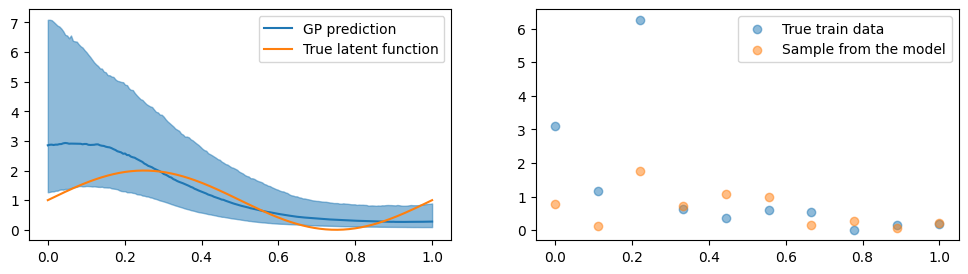

In [9]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean.detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower.detach().cpu().numpy(),
    upper.detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, scale(test_x), label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y, alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim.cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

## Next steps

This example probably could've also been done (slightly easier) using the high-level Pyro integration, or using GPyTorch's native SVGP implementation. The low-level interface really comes in handy when a gpytorch Likelihood is difficult to define. For an example of this, see the [next example](./Cox_Process_Example.ipynb) which uses the low-level interface to infer the intensity function of a Cox process.